# 207 Final Project - Peter Benzoni

## Data Setup
 
### Load the data, creating the appropriate files if they dont already exist

In [14]:
import pandas as pd
BALANCED_DATASET = False
# Check if combined-news-articles.csv already exists:
# If it does, load the dataframe from the csv file
# If it doesn't, create the dataframe from the original datasets
try:
    df = pd.read_csv('combined-news-articles.csv')
    BALANCED_DATASET = True

except FileNotFoundError:
    site_map = {
        "http://en.people.cn/": "People's Daily",
        "http://global.chinadaily.com.cn/": "China Daily",
        "http://www.globaltimes.cn/": "Global Times",
        "http://www.xinhuanet.com/english/": "Xinhua" ,
        "https://www.cgtn.com/": "CGTN",
        "xinhuanet.com (english)": "Xinhua",
    }

    # Load the datasets
    df = pd.read_csv('all-the-news-2-1.csv')
    df_china = pd.read_csv('China_Articles.csv')


### Filter the Data to desired dates and publications

In [15]:
if not BALANCED_DATASET:
    # Filter out articles from specified publications, excluding tabloid, significantly slanted, analysis/long-form, and opinion publications (and including news-first publications)
    included_publications = ["Axios", "Business Insider", "CNBC", "CNN", "Fox News", "Reuters", "The Hill", "The New York Times", "Washington Post",]
    df = df[df['publication'].isin(included_publications)]

    # filter to only articles from 7-2019 to 7-2020 to match df_china
    df = df[((df['year'] == 2019) & (df['month'] >= 7)) | ((df['year'] == 2020) & (df['month'] <= 7))]

    # filter out articles from specified publications for df_china
    excluded_publications_china = ['china-un.org (english)']
    df_china = df_china[~df_china['site'].isin(excluded_publications_china)]

    # replace sites with publication names for df_china
    df_china['publication'] = df_china['site'].map(site_map)


### Normalize formatting and columns

In [16]:
if not BALANCED_DATASET:
    # match date columns for df_china to df columns (date, year, month)
    df_china['date'] = pd.to_datetime(df_china['published'], format='mixed')
    df_china['year'] = df_china['date'].dt.year
    df_china['month'] = df_china['date'].dt.month

    # Handling missing values - remove empty articles
    df = df[df['title'].notna()]
    df_china = df_china[df_china['title'].notna()]
    df = df[df['article'].notna()]
    df_china = df_china[df_china['excerpt'].notna()]    

    # Convert the data into a format suitable for NLP analysis; Matching the first 1000 characters available in the other dataset
    df['combined_content'] = df['title'].astype(str) + ': ' + df['article'].str[:1000].astype(str)
    df_china['combined_content'] = df_china['title'].astype(str) + ': ' + df_china['excerpt'].astype(str)


### Balance datasets
For the "all the news" dataset: The smallest publication here is Buzzfeed News with 3,657 articles. To ensure that Axios is represented each month, set N to be around 600 (since 7674/12 = 614). 

For the Chinese state media dataset: The smallest publication is Global Times with 5,242 articles. To ensure representation each month, set N to around 430 (since 5242/12 = 437).

That way, the data should be balanced by publication and date. We could balance by actor as well (china vs non-china, but its useful to have a boarder context the chinese media fits into) 

In [17]:
if not BALANCED_DATASET:
    # get and print length of each publication , to justify balancing the datasets
    print(df['publication'].value_counts())
    print(df_china['publication'].value_counts())
    
    balanced_df = pd.DataFrame()
    balanced_df_china = pd.DataFrame()

    for year in df['year'].unique():
        for month in df['month'].unique():
            # Sample N articles from each publication in df for the specific month and year
            N = 610
            temp_df = df[(df['year'] == year) & (df['month'] == month)]
            sampled_df = temp_df.groupby('publication').apply(lambda x: x.sample(min(len(x), N))).reset_index(drop=True)
            balanced_df = pd.concat([balanced_df, sampled_df], ignore_index=True)
            
            # Do the same for df_china
            N = 430
            temp_df_china = df_china[(df_china['year'] == year) & (df_china['month'] == month)]
            sampled_df_china = temp_df_china.groupby('publication').apply(lambda x: x.sample(min(len(x), N))).reset_index(drop=True)
            balanced_df_china = pd.concat([balanced_df_china, sampled_df_china], ignore_index=True)



### Combine the Balanced datasets

In [18]:
if not BALANCED_DATASET:

    # Combine the dataframes, keeping only the intersection of columns
    df = pd.concat([balanced_df, balanced_df_china], axis=0, join='inner')
    print(df['publication'].value_counts())
    

    # Now, df['combined_content'] can be used for NLP analysis
    print(df.head())

    # Save the dataframe to a csv file for future use
    df.to_csv('combined-news-articles.csv', index=False)

In [19]:
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.corpus import stopwords
# # Convert text to lowercase (optional)
# df['combined_content'] = df['combined_content'].str.lower()

# # Use a CountVectorizer with dtype=np.float32 to reduce memory usage
# vectorizer = CountVectorizer(stop_words=stopwords.words('english'), dtype=np.float32)
# word_count = vectorizer.fit_transform(df['combined_content'])

# # Convert to a sparse DataFrame
# words = vectorizer.get_feature_names_out()
# word_count_df = pd.DataFrame.sparse.from_spmatrix(word_count, columns=words, index=df['publication'])

# # Calculate frequency of each word in each publication
# word_freq = word_count_df.div(word_count_df.sum(axis=1), axis=0)

# # Calculate uniqueness score
# uniqueness_score = word_freq.div(word_freq.mean())

# # Get the top 25 unique words for each publication
# top_unique_words = uniqueness_score.apply(lambda x: x.nlargest(25).index.tolist())


# print(top_unique_words)

## Topic Modeling

Start by installing necessary libraries

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, Phrases
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import string
import re
import pprint
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benzo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benzo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### NLP Preprocessing

In [21]:
# Tokenization and Stop-word removal
def preprocess(documents):
    # Lowercasing
    documents = [doc.lower() for doc in documents]

    # Tokenization
    documents_tokens = [nltk.word_tokenize(doc) for doc in documents]

    # Stop Words Removal
    stop_words = set(stopwords.words('english'))
    documents_tokens = [[word for word in doc if word not in stop_words] for doc in documents_tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    documents_lemmatized = [[lemmatizer.lemmatize(word) for word in doc] for doc in documents_tokens]

    print("lemmatized")

    # Stemming
    stemmer = SnowballStemmer("english")
    documents_stemmed = [[stemmer.stem(word) for word in doc] for doc in documents_lemmatized]

    # Removing Numbers and Punctuation
    regex = re.compile('[%s]' % re.escape(string.punctuation + string.digits))
    documents_tokens = [[regex.sub('', word) for word in doc] for doc in documents_stemmed]
    documents_tokens = [[word for word in doc if word] for doc in documents_stemmed]  # Remove empty strings

    print("numbers and punctuation removed")

    
    # Removing Short Words
    documents_tokens = [[word for word in doc if len(word) > 2] for doc in documents_tokens]


    # TF-IDF Transformation
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform([' '.join(doc) for doc in documents_tokens])

    print("tf-idf transformed")

    # Bi-grams and N-grams
    bigram = Phrases(documents_tokens, min_count=5, threshold=50)
    documents_bigrams = [bigram[doc] for doc in documents_tokens]

    print("bigrams and n-grams created")

    # # Removing Frequent and Rare Words - save this for later?
    # freq_thresh = 0.95
    # rare_thresh = 0.05
    # word_freq = X.sum(axis=0).tolist()[0]
    # features = vectorizer.get_feature_names_out()
    # features_list = list(features)
    # docs_filtered = [[word for word in doc if word in features_list and word_freq[features_list.index(word)] < freq_thresh and word_freq[features_list.index(word)] > rare_thresh] for doc in documents_tokens]

    # print("freq/rare words removed")

    # Word Embeddings - save this for later?
    # model = Word2Vec(sentences=documents_tokens, vector_size=100, window=5, min_count=1, workers=4)
    # model.save("word2vec.model")


    return documents_tokens, documents_bigrams

documents_tokens, documents_bigrams = preprocess(df['combined_content'])

lemmatized
numbers and punctuation removed
tf-idf transformed
bigrams and n-grams created


## Building models

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Before we pick how many topics we want to model, we can use the coherence score to evaluate each of the models
# Comment this out after the first run, as it takes a while to run
# model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents_bigrams, start=5, limit=50, step=5)
# print(coherence_values)

# model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents_tokens, start=5, limit=50, step=5)
# print(coherence_values)


### LDA - Single word model

In [23]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(documents_tokens)

# Filter out words that occur in less than 20 documents, or more than 70% of the documents.
#dictionary.filter_extremes(no_below=20, no_above=0.7)

# Convert the dictionary into a bag-of-words corpus.
corpus = [dictionary.doc2bow(doc) for doc in documents_tokens]

# Train the LDA model
num_topics = 25  
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

# Print the topics
pprint.pprint(lda.print_topics(num_words=15))

[(12,
  '0.025*"percent" + 0.014*"market" + 0.014*"year" + 0.012*"u.s." + '
  '0.011*"dollar" + 0.011*"billion" + 0.011*"economi" + 0.010*"trade" + '
  '0.010*"said" + 0.009*"million" + 0.009*"china" + 0.009*"econom" + '
  '0.009*"yuan" + 0.009*"global" + 0.007*"price"'),
 (5,
  '0.038*"minist" + 0.017*"said" + 0.017*"prime" + 0.014*"parti" + '
  '0.013*"meet" + 0.012*"presid" + 0.011*"deal" + 0.010*"britain" + '
  '0.009*"leader" + 0.009*"govern" + 0.009*"countri" + 0.009*"london" + '
  '0.007*"johnson" + 0.007*"agreement" + 0.007*"british"'),
 (23,
  '0.019*"technolog" + 0.019*"onlin" + 0.018*"compani" + 0.018*"busi" + '
  '0.014*"platform" + 0.013*"develop" + 0.013*"research" + 0.012*"video" + '
  '0.011*"industri" + 0.010*"data" + 0.009*"zhejiang" + 0.009*"servic" + '
  '0.009*"use" + 0.009*"inform" + 0.007*"innov"'),
 (19,
  '0.023*"citi" + 0.021*"new" + 0.010*"vehicl" + 0.008*"car" + 0.008*"shop" + '
  '0.008*"custom" + 0.007*"restaur" + 0.007*"store" + 0.007*"local" + '
  '0.007

In [24]:
# Print the topics in order
num_topics = 25  
for i in range(num_topics):
    topic = lda.show_topic(i,topn=15)  # Gets the topic
    for weight, word in topic:
        print(i, ": ", weight, " - ", word)

0 :  photo  -  0.012216182
0 :  year  -  0.009906951
0 :  time  -  0.009056958
0 :  new  -  0.008405568
0 :  show  -  0.008331466
0 :  one  -  0.008325437
0 :  work  -  0.0073152836
0 :  wang  -  0.0067067407
0 :  peopl  -  0.0065296064
0 :  video  -  0.0064533446
0 :  like  -  0.006439583
0 :  make  -  0.0062543266
0 :  n't  -  0.0058760215
0 :  life  -  0.0057382183
0 :  novel  -  0.005138783
1 :  trump  -  0.05598334
1 :  presid  -  0.042139404
1 :  hous  -  0.032778744
1 :  committe  -  0.021187197
1 :  senat  -  0.016157167
1 :  donald  -  0.016029608
1 :  white  -  0.015218066
1 :  impeach  -  0.014712891
1 :  washington  -  0.013876924
1 :  democrat  -  0.009845367
1 :  trial  -  0.0091986805
1 :  vote  -  0.008390516
1 :  u.s.  -  0.007880039
1 :  john  -  0.0071687214
1 :  republican  -  0.007152523
2 :  infect  -  0.04207154
2 :  home  -  0.025149299
2 :  tourism  -  0.020934295
2 :  outbreak  -  0.01088177
2 :  travel  -  0.008959136
2 :  tourist  -  0.0087641645
2 :  hotel 

### LDA - Bigrams

In [25]:
# Create a dictionary representation of the documents with bigrams.
dictionary_bigrams = Dictionary(documents_bigrams)

# Filter out words that occur in less than 20 documents, or more than 70% of the documents.
#dictionary_bigrams.filter_extremes(no_below=20, no_above=0.7)

# Convert the dictionary into a bag-of-words corpus.
corpus_bigrams = [dictionary_bigrams.doc2bow(doc) for doc in documents_bigrams]

# Train the LDA model on the bigram corpus
num_topics = 25 
lda_bigrams = LdaModel(corpus=corpus_bigrams, id2word=dictionary_bigrams, num_topics=num_topics, random_state=42)

# Print the topics for the model trained on bigrams
pprint.pprint(lda_bigrams.print_topics(num_words=15))

[(23,
  '0.030*"said" + 0.023*"polic" + 0.017*"offic" + 0.014*"report" + '
  '0.012*"inform" + 0.011*"secur" + 0.011*"spokesperson" + 0.010*"accord" + '
  '0.008*"statement" + 0.008*"kill" + 0.007*"two" + 0.007*"nigeria" + '
  '0.006*"inspect" + 0.006*"employe" + 0.006*"said.th"'),
 (24,
  '0.020*"said" + 0.019*"itali" + 0.017*"govern" + 0.016*"prime_minist" + '
  '0.016*"london" + 0.015*"britain" + 0.015*"germani" + 0.013*"countri" + '
  '0.013*"reopen" + 0.012*"minist" + 0.012*"european" + 0.011*"europ" + '
  '0.010*"german" + 0.010*"new" + 0.010*"british"'),
 (8,
  '0.034*"china" + 0.022*"percent" + 0.015*"global" + 0.014*"trade" + '
  '0.014*"market" + 0.013*"economi" + 0.013*"u.s." + 0.012*"said" + '
  '0.010*"year" + 0.009*"econom" + 0.008*"countri" + 0.008*"dollar" + '
  '0.007*"product" + 0.007*"export" + 0.007*"price"'),
 (0,
  '0.022*"outbreak" + 0.019*"epidem" + 0.018*"health" + 0.018*"virus" + '
  '0.018*"said" + 0.016*"trump" + 0.012*"expert" + 0.012*"report" + '
  '0.011*

### Let's just use the single word topics:
Manual coding:
1. Photos and Videos
2. US Politics esp Trump 
3. COVID19
4. International relations
5. Education
6. British Politics
7. Civil Unrest and Protests
8. Covid19 Response
9. SEA politics
10. 2020 Democratic Primary
11. China
12. Arts and Int'l culture
13. Economics
14. Space and Elon Musk
15. Russian Int'l Relations 
16. Natural resources
17. Olympics and sports
18. Crime
19. US Domestic Politics
20. Commerce
21. Healthcare
22. Travel
23. Asian Int'l Politics
24. Technology
25. Legislation and Law

## Using that list lets get percentage for each topic

### Preprocess


In [26]:
import matplotlib.pyplot as plt
import numpy as np

chinese_publications = [
    "People's Daily", "China Daily", "Global Times", "Xinhua", "CGTN"
]

# Split the dataframe based on the publication and preprocess the data
df_china = df[df['publication'].isin(chinese_publications)]
df_general = df[~df['publication'].isin(chinese_publications)]

corpus_df_china, corpus_df_china_bg = preprocess(df_china['combined_content'])
corpus_df, corpus_df_bg = preprocess(df_general['combined_content'])


# Define the topics based on the manually coded indices
topics = [
    "Photos and Videos",
    "US Politics esp Trump",
    "COVID19",
    "International relations",
    "Education",
    "British Politics",
    "Civil Unrest and Protests",
    "Covid19 Response",
    "SEA politics",
    "2020 Democratic Primary",
    "China",
    "Arts and Int'l culture",
    "Economics",
    "Space and Elon Musk",
    "Russian Int'l Relations",
    "Natural resources",
    "Olympics and sports",
    "Crime",
    "US Domestic Politics",
    "Commerce",
    "Healthcare",
    "Travel",
    "Asian Int'l Politics",
    "Technology",
    "Legislation and Law"
]


lemmatized
numbers and punctuation removed
tf-idf transformed
bigrams and n-grams created
lemmatized
numbers and punctuation removed
tf-idf transformed
bigrams and n-grams created


39954
39954
14242


C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\3194064255.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general["topic"] = get_most_likely_topic(lda, corpus_df_bow)


14242
                      date  year  month          author  \
39954  2019-07-06 21:04:00  2019    7.0               0   
39955  2019-07-11 11:31:57  2019    7.0  Source: Xinhua   
39956  2019-07-06 02:07:09  2019    7.0  Source: Xinhua   
39957  2019-07-30 04:29:14  2019    7.0  Source: Xinhua   
39958  2019-07-06 03:48:41  2019    7.0  Source: Xinhua   

                                                   title publication  \
39954      A Hotan woman  from farmer to factory worker        CGTN   
39955  Pic story: Belt and Road Initiative brings opp...      Xinhua   
39956  Japan-China summit will push forward bilateral...      Xinhua   
39957  Zambia to benefit from China through enhanced ...      Xinhua   
39958             Chinese president meets Bangladeshi PM      Xinhua   

                                        combined_content  topic  
39954  A Hotan woman  from farmer to factory worker:...      8  
39955  Pic story: Belt and Road Initiative brings opp...     19  
39956  J

C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\3194064255.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_china["topic"] = get_most_likely_topic(lda, corpus_df_china_bow)


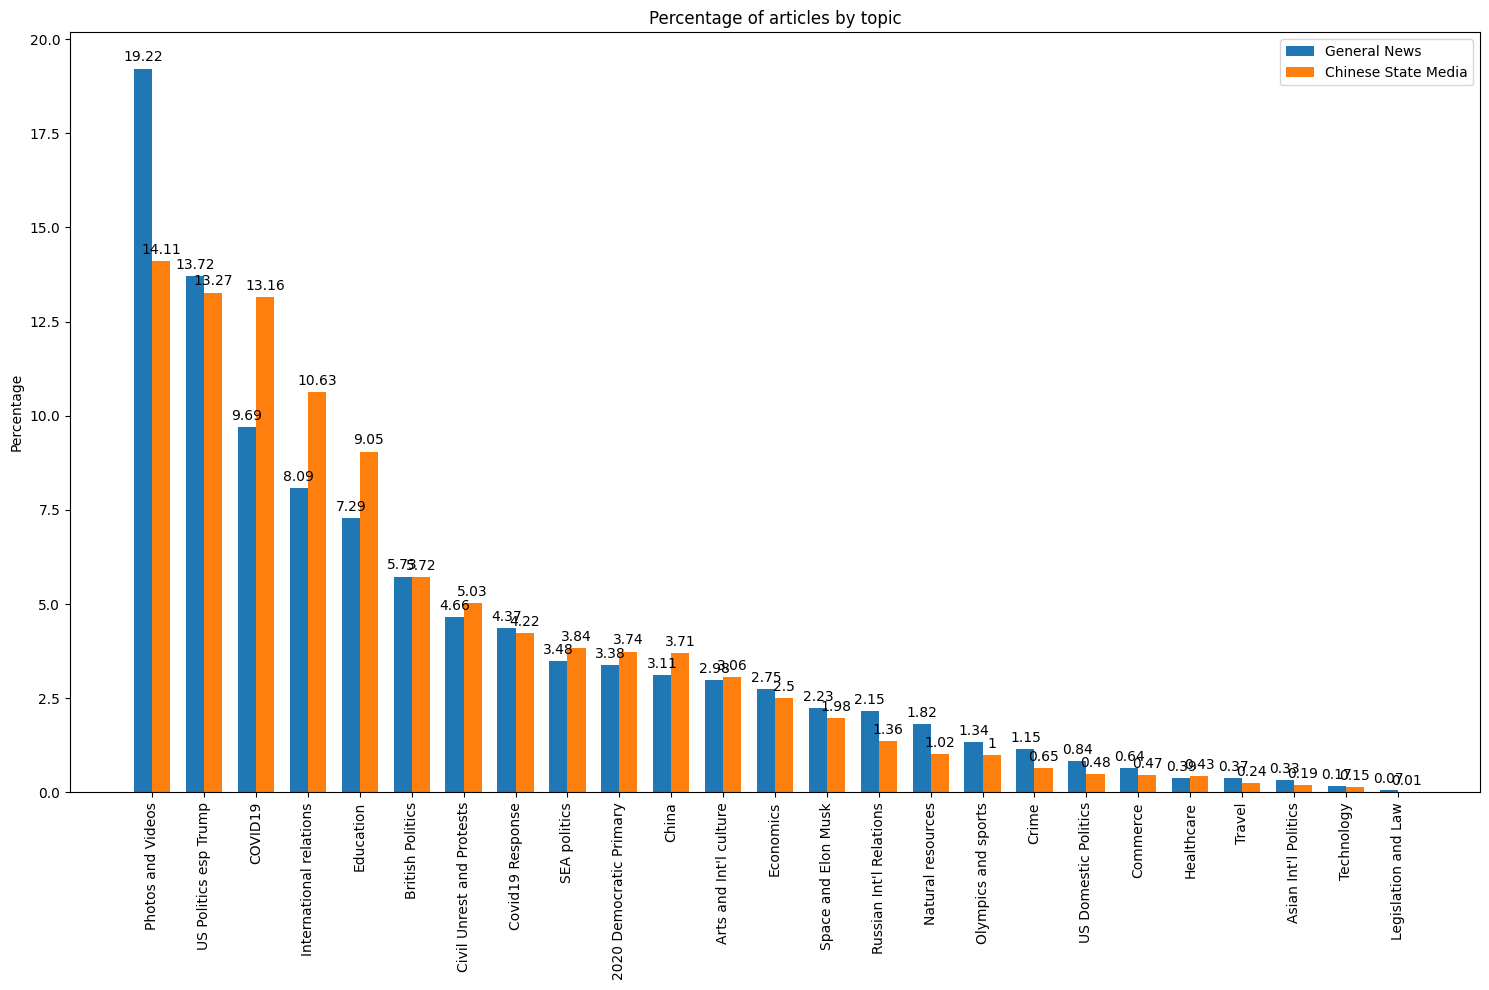

In [27]:

# Function to predict the most likely topic for each document
def get_most_likely_topic(lda_model, corpus):
    print(len(corpus))
    topic_assignments = []
    for doc in corpus:
        topics_probs = lda_model.get_document_topics(doc)
        most_likely_topic = max(topics_probs, key=lambda x: x[1])[0]
        topic_assignments.append(most_likely_topic)
    print(len(topic_assignments))
    return topic_assignments


corpus_df_bow = [dictionary.doc2bow(text) for text in corpus_df]
corpus_df_china_bow = [dictionary.doc2bow(text) for text in corpus_df_china]


# Now, use the BoW representations for topic predictions
df_general["topic"] = get_most_likely_topic(lda, corpus_df_bow)
df_china["topic"] = get_most_likely_topic(lda, corpus_df_china_bow)

#print(df_general.head())
print(df_china.head())


# Calculate topic percentages for both datasets
df_topic_percentage = df_general["topic"].value_counts(normalize=True) * 100
df_china_topic_percentage = df_china["topic"].value_counts(normalize=True) * 100

# Visualize the data
x = np.arange(len(topics))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(x - width/2, round(df_topic_percentage,2), width, label='General News')
rects2 = ax.bar(x + width/2, round(df_china_topic_percentage,2 ), width, label='Chinese State Media')

ax.set_ylabel('Percentage')
ax.set_title('Percentage of articles by topic')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=90)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

## Testing Classification models
Creating classification models with logistic regression and random forest with the following variations:

Logistic Regression: C values of 0.01, 0.1, 1, 10
Random forest with # of trees: 10, 50, 100, 200


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

chinese_publications = [
    "People's Daily", "China Daily", "Global Times", "Xinhua", "CGTN"
]

df["label"] = df['publication'].isin(chinese_publications)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['combined_content'])

# Splitting the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Train and Eval model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

# Logistic Regression with varying C values
for C in [0.01, 0.1, 1, 10]:
    print(f"Logistic Regression with C={C}")
    model = LogisticRegression(C=C)
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

# Random Forest with varying number of trees
for n_estimators in [10, 50, 100, 200]:
    print(f"Random Forest with n_estimators={n_estimators}")
    model = RandomForestClassifier(n_estimators=n_estimators)
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

# SVM with different kernels
for kernel in ['linear', 'rbf', 'poly']:
    print(f"SVM with kernel={kernel}")
    model = SVC(kernel=kernel)
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test)


Logistic Regression with C=0.01
              precision    recall  f1-score   support

       False       0.76      1.00      0.86      7992
        True       0.95      0.13      0.22      2848

    accuracy                           0.77     10840
   macro avg       0.86      0.56      0.54     10840
weighted avg       0.81      0.77      0.70     10840

Logistic Regression with C=0.1
              precision    recall  f1-score   support

       False       0.89      0.99      0.93      7992
        True       0.94      0.66      0.77      2848

    accuracy                           0.90     10840
   macro avg       0.92      0.82      0.85     10840
weighted avg       0.90      0.90      0.89     10840

Logistic Regression with C=1
              precision    recall  f1-score   support

       False       0.96      0.99      0.97      7992
        True       0.97      0.87      0.92      2848

    accuracy                           0.96     10840
   macro avg       0.96      0.93   

C:\Users\benzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.97      0.99      0.98      7992
        True       0.98      0.92      0.95      2848

    accuracy                           0.97     10840
   macro avg       0.97      0.96      0.96     10840
weighted avg       0.97      0.97      0.97     10840

Random Forest with n_estimators=10
              precision    recall  f1-score   support

       False       0.93      0.99      0.96      7992
        True       0.96      0.79      0.87      2848

    accuracy                           0.94     10840
   macro avg       0.95      0.89      0.91     10840
weighted avg       0.94      0.94      0.93     10840

Random Forest with n_estimators=50
              precision    recall  f1-score   support

       False       0.96      0.99      0.97      7992
        True       0.98      0.87      0.92      2848

    accuracy                           0.96     10840
   macro avg       0.97      0.93      0.95     10840
weig

### Analyzing the sentiment of individual articles then averaging

In [42]:
from textblob import TextBlob
import pandas as pd

# Define a function to calculate sentiment
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # returns sentiment score

# Apply the function to calculate sentiment for each article
df_general['sentiment'] = df_general['combined_content'].apply(calculate_sentiment)
df_china['sentiment'] = df_china['combined_content'].apply(calculate_sentiment)

# Group by topic and calculate average sentiment
avg_sentiment_general = df_general.groupby('topic')['sentiment'].mean()
avg_sentiment_china = df_china.groupby('topic')['sentiment'].mean()

# Optionally, you can display the results
print("Average Sentiment for General News by Topic:")
print(avg_sentiment_general)
print("\nAverage Sentiment for Chinese State Media by Topic:")
print(avg_sentiment_china)

C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\1474105753.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['sentiment'] = df_general['combined_content'].apply(calculate_sentiment)


Average Sentiment for General News by Topic:
topic
0     0.124187
1     0.072859
2     0.110881
3     0.075174
4     0.086046
5     0.069897
6     0.043574
7     0.052130
8     0.047593
9     0.123461
10    0.039442
11    0.111845
12    0.048060
13    0.104053
14    0.038901
15    0.089028
16    0.083976
17   -0.004716
18    0.048078
19    0.103203
20    0.066941
21    0.046896
22    0.024949
23    0.113210
24    0.069524
Name: sentiment, dtype: float64

Average Sentiment for Chinese State Media by Topic:
topic
0     0.117771
1     0.061103
2     0.118665
3     0.093274
4     0.116935
5     0.071411
6     0.023928
7     0.072209
8     0.071486
9     0.130862
10    0.075624
11    0.144114
12    0.069413
13    0.089157
14    0.017751
15   -0.003842
16    0.081070
17   -0.008528
18    0.005893
19    0.094049
20    0.093046
21    0.065779
22    0.053740
23    0.101352
24    0.052552
Name: sentiment, dtype: float64


C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\1474105753.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_china['sentiment'] = df_china['combined_content'].apply(calculate_sentiment)


### K-Means Clustering and Named Entity Extraction, compared by topic

Choosing the right number of clusters

C:\Users\benzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

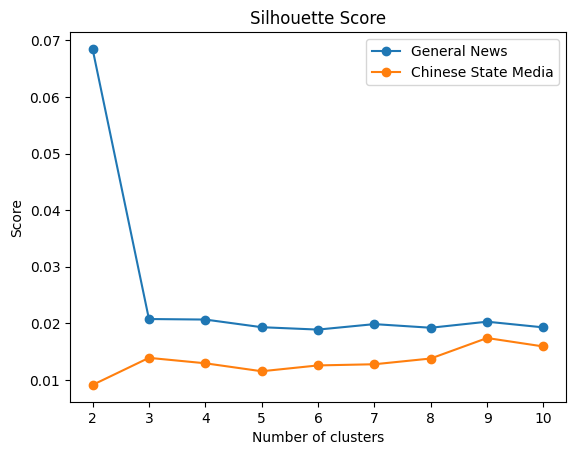

In [45]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Silhouette Score
def calculate_silhouette(data):
    silhouette = []
    for n in range(2, 11):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette.append(score)
    return silhouette

silhouette_general = calculate_silhouette(X_general)
silhouette_china = calculate_silhouette(X_china)

plt.plot(range(2, 11), silhouette_general, marker='o', label='General News')
plt.plot(range(2, 11), silhouette_china, marker='o', label='Chinese State Media')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

In [48]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

nlp = spacy.load('en_core_web_sm')

# Named Entity Recognition
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

df_general['entities'] = df_general['combined_content'].apply(extract_entities)
df_china['entities'] = df_china['combined_content'].apply(extract_entities)

# Feature Extraction for Clustering
vectorizer = TfidfVectorizer(max_features=1000)
X_general = vectorizer.fit_transform(df_general['combined_content'])
X_china = vectorizer.fit_transform(df_china['combined_content'])

# K-means Clustering
k = 9  
kmeans_general = KMeans(n_clusters=k, random_state=42).fit(X_general)
kmeans_china = KMeans(n_clusters=k, random_state=42).fit(X_china)

df_general['cluster'] = kmeans_general.labels_
df_china['cluster'] = kmeans_china.labels_

# Analysis
# Compare clusters by topics
topic_cluster_general = df_general.groupby(['topic', 'cluster']).size().unstack(fill_value=0)
topic_cluster_china = df_china.groupby(['topic', 'cluster']).size().unstack(fill_value=0)

print("General News Topic-Cluster Distribution:")
print(topic_cluster_general)
print("\nChinese State Media Topic-Cluster Distribution:")
print(topic_cluster_china)

C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\281375264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['entities'] = df_general['combined_content'].apply(extract_entities)
C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\281375264.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_china['entities'] = df_china['combined_content'].apply(extract_entities)
C:\Users\benzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-

General News Topic-Cluster Distribution:
cluster     0    1     2     3    4     5     6     7     8
topic                                                      
0         255  912  1148    51  419    54  1837  2807   196
1          74   71   136    80  185    38    25   237  3027
2         105   21    26     6   96     5   142   324     4
3          17    1     1     0    9     0     0     1     0
4          10   19     9     1   35     1    13    59     1
5         448   16   129     2   91    93     8   328   129
6          20    0     2     1   10    12     4    19     0
7        1711   37    82    21  103   144    30  1058    48
8         100   18    32     7   88    10    25   801    19
9          24   92    88  1657  139     2     8   150   128
10         14    3     0     0   40   367     0    35     1
11         10   55    44     2   76     0     5    59     6
12       3122    4    22    12  273  1169    69   738    73
13         17    3    17     0   21     4     7    88     0

C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\281375264.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['cluster'] = kmeans_general.labels_
C:\Users\benzo\AppData\Local\Temp\ipykernel_29528\281375264.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_china['cluster'] = kmeans_china.labels_


### Analyzing K Means  Clusters


In [49]:
from collections import Counter
import pandas as pd

def get_top_features_cluster(tfidf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction == label)  # indices for each cluster
        x_means = np.mean(tfidf_array[id_temp], axis = 0)  # mean tf-idf value for each feature in the cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats]  # indices with top mean scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

# Extract top features for each cluster
n_feats = 10  
dfs_general = get_top_features_cluster(X_general.toarray(), kmeans_general.labels_, n_feats)
dfs_china = get_top_features_cluster(X_china.toarray(), kmeans_china.labels_, n_feats)

# Display top features for each cluster
for i in range(len(dfs_general)):
    print(f"Top features for General News Cluster {i}:")
    print(dfs_general[i])
    print("\n")

for i in range(len(dfs_china)):
    print(f"Top features for Chinese State Media Cluster {i}:")
    print(dfs_china[i])
    print("\n")

Top features for General News Cluster 0:
    features     score
0       this  0.149793
1   tourists  0.097154
2  institute  0.078030
3        our  0.073894
4         am  0.067018
5       park  0.057322
6      build  0.051957
7      korea  0.050924
8     school  0.045580
9       role  0.044255


Top features for General News Cluster 1:
    features     score
0      hours  0.261476
1       this  0.209216
2      sides  0.206948
3         am  0.105976
4   tourists  0.101404
5  institute  0.101349
6        our  0.099602
7    website  0.074413
8     france  0.055815
9       park  0.053510


Top features for General News Cluster 2:
    features     score
0       this  0.228998
1       hold  0.143288
2         if  0.141609
3  institute  0.109573
4   tourists  0.107230
5        our  0.103377
6         am  0.101497
7    website  0.090353
8       park  0.058471
9     france  0.056092


Top features for General News Cluster 3:
    features     score
0       this  0.173545
1       best  0.134382
2 

In [51]:
def compare_clusters_labels(df, num_clusters):
    cross_tab = pd.crosstab(index=df['topic'], columns=df['cluster'], normalize='index')
    return cross_tab * 100  # Percentage representation

# Compare clusters with topics for General News
comparison_general = compare_clusters_labels(df_general, k)
print("Comparison between Clusters and Topics for General News:")
print(comparison_general)

# Compare clusters with topics for Chinese State Media
comparison_china = compare_clusters_labels(df_china, k)
print("\nComparison between Clusters and Topics for Chinese State Media:")
print(comparison_china)

Comparison between Clusters and Topics for General News:
cluster          0          1          2          3          4          5  \
topic                                                                       
0         3.320745  11.876546  14.949863   0.664149   5.456440   0.703217   
1         1.910664   1.833204   3.511490   2.065582   4.776659   0.981152   
2        14.403292   2.880658   3.566529   0.823045  13.168724   0.685871   
3        58.620690   3.448276   3.448276   0.000000  31.034483   0.000000   
4         6.756757  12.837838   6.081081   0.675676  23.648649   0.675676   
5        36.012862   1.286174  10.369775   0.160772   7.315113   7.475884   
6        29.411765   0.000000   2.941176   1.470588  14.705882  17.647059   
7        52.906617   1.144094   2.535560   0.649351   3.184910   4.452690   
8         9.090909   1.636364   2.909091   0.636364   8.000000   0.909091   
9         1.048951   4.020979   3.846154  72.421329   6.075175   0.087413   
10        3.043478 

### Evaluating Unique Entities

In [53]:
def calculate_unique_entity_percentage_per_topic(df):
    topic_unique_percentage = {}

    # Group by topic and aggregate entities
    grouped = df.groupby('topic')['entities'].agg(sum)

    for topic, entities in grouped.items():
        total_entities = len(entities)
        unique_entities = len(set(entities))
        unique_percentage = (unique_entities / total_entities) * 100 if total_entities > 0 else 0
        topic_unique_percentage[topic] = (unique_percentage, unique_entities, total_entities)

    return topic_unique_percentage

# Calculate for General News
unique_percentage_per_topic_general = calculate_unique_entity_percentage_per_topic(df_general)
print("General News Unique Entity Percentages by Topic:")
for topic, stats in unique_percentage_per_topic_general.items():
    print(f"{topic}: {stats[0]:.2f}% unique entities ({stats[1]} out of {stats[2]})")

# Calculate for Chinese State Media
unique_percentage_per_topic_china = calculate_unique_entity_percentage_per_topic(df_china)
print("\nChinese State Media Unique Entity Percentages by Topic:")
for topic, stats in unique_percentage_per_topic_china.items():
    print(f"{topic}: {stats[0]:.2f}% unique entities ({stats[1]} out of {stats[2]})")


General News Unique Entity Percentages by Topic:
0: 33.03% unique entities (38592 out of 116822)
1: 13.46% unique entities (11776 out of 87470)
2: 45.37% unique entities (4910 out of 10822)
3: 47.42% unique entities (450 out of 949)
4: 61.77% unique entities (1317 out of 2132)
5: 21.10% unique entities (5601 out of 26543)
6: 53.62% unique entities (466 out of 869)
7: 29.35% unique entities (17589 out of 59923)
8: 38.62% unique entities (7248 out of 18769)
9: 13.99% unique entities (7618 out of 54441)
10: 28.25% unique entities (2454 out of 8687)
11: 57.52% unique entities (2647 out of 4602)
12: 22.53% unique entities (26783 out of 118903)
13: 43.48% unique entities (1297 out of 2983)
14: 21.30% unique entities (6311 out of 29626)
15: 52.76% unique entities (1042 out of 1975)
16: 34.38% unique entities (13721 out of 39908)
17: 29.71% unique entities (15855 out of 53370)
18: 75.16% unique entities (844 out of 1123)
19: 38.74% unique entities (5952 out of 15364)
20: 33.88% unique entities